# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [31]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)])

# Create training set and define training dataloader
training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(training_data, batch_size=95, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=95)

# Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Torchvision has handy transformations like cropping, resizing and normalizing. I thought of trying only normalizing first because that's what was shown in the previous lessons. If it didn't had worked I would have tried cropping or resizing images. The values of mean and standard deviation were found out to be standard values for MNIST dataset on the internet. So I selected those values for normalizing.

In [32]:
print("Size of Training dataset: {}".format(len(train_loader)))
print("Size of Testing dataset: {}".format(len(test_loader)))

Size of Training dataset: 632
Size of Testing dataset: 106


In [33]:
print("Shape of images in Training dataset: {}".format(training_data[0][0].shape))
print("Shape of images in Testing dataset: {}".format(test_data[0][0].shape))

Shape of images in Training dataset: torch.Size([1, 28, 28])
Shape of images in Testing dataset: torch.Size([1, 28, 28])


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [34]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


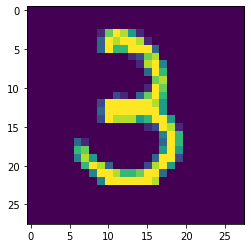

7


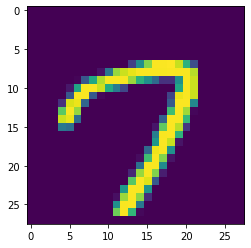

4


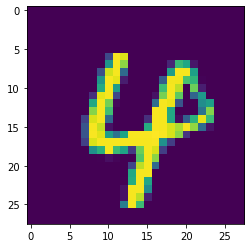

1


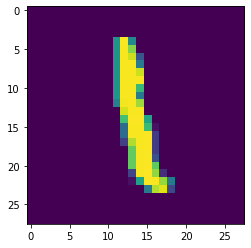

3


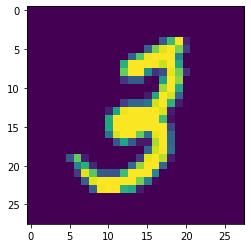

In [35]:
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [37]:
optimizer = optim.SGD(net.parameters(), lr=0.001,  momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [38]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


Epoch 1 training accuracy: 70.56% training loss: 1.00637
Epoch 2 training accuracy: 84.13% training loss: 0.38349
Epoch 3 training accuracy: 86.27% training loss: 0.31203
Epoch 4 training accuracy: 87.43% training loss: 0.26991
Epoch 5 training accuracy: 88.21% training loss: 0.23974
Epoch 6 training accuracy: 88.94% training loss: 0.21579
Epoch 7 training accuracy: 89.57% training loss: 0.19347
Epoch 8 training accuracy: 90.07% training loss: 0.17689
Epoch 9 training accuracy: 90.44% training loss: 0.16288
Epoch 10 training accuracy: 90.72% training loss: 0.15272


Plot the training loss (and validation loss/accuracy, if recorded).

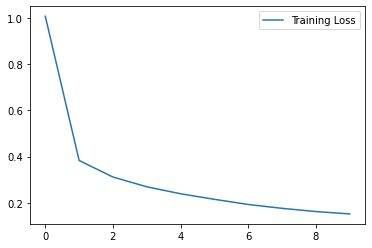

In [39]:
plt.plot(train_loss_history, label="Training Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [40]:
num_epochs = 10
test_loss_history = list()

for epoch in range(num_epochs):
    test_loss = 0.0
    test_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Epoch {epoch + 1} Testing accuracy: {test_correct/len(test_loader):.2f}% testing loss: {test_loss/len(test_loader):.5f}')
    test_loss_history.append(test_loss/len(test_loader))


Epoch 1 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 2 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 3 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 4 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 5 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 6 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 7 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 8 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 9 Testing accuracy: 90.66% testing loss: 0.12980
Epoch 10 Testing accuracy: 90.66% testing loss: 0.12980


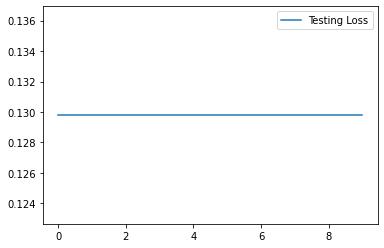

In [41]:
plt.plot(test_loss_history, label="Testing Loss")
plt.legend()
plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [54]:
optimizer = optim.SGD(net.parameters(), lr=0.002,  momentum=0.8)
criterion = nn.CrossEntropyLoss()

In [55]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

Epoch 1 training accuracy: 68.67% training loss: 1.04400
Epoch 2 training accuracy: 83.50% training loss: 0.41297
Epoch 3 training accuracy: 85.53% training loss: 0.33329
Epoch 4 training accuracy: 86.96% training loss: 0.28810
Epoch 5 training accuracy: 87.88% training loss: 0.25401
Epoch 6 training accuracy: 88.51% training loss: 0.22759
Epoch 7 training accuracy: 89.16% training loss: 0.20672
Epoch 8 training accuracy: 89.70% training loss: 0.18830
Epoch 9 training accuracy: 89.99% training loss: 0.17592
Epoch 10 training accuracy: 90.36% training loss: 0.16412


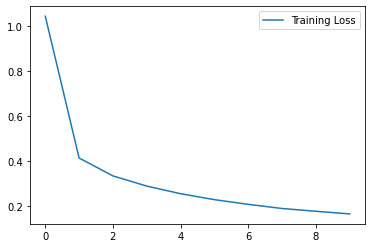

In [56]:
plt.plot(train_loss_history, label="Training Loss")
plt.legend()
plt.show()

In [57]:
num_epochs = 10
test_loss_history = list()

for epoch in range(num_epochs):
    test_loss = 0.0
    test_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Epoch {epoch + 1} Testing accuracy: {test_correct/len(test_loader):.2f}% testing loss: {test_loss/len(test_loader):.5f}')
    test_loss_history.append(test_loss/len(test_loader))

Epoch 1 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 2 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 3 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 4 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 5 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 6 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 7 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 8 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 9 Testing accuracy: 90.75% testing loss: 0.12842
Epoch 10 Testing accuracy: 90.75% testing loss: 0.12842


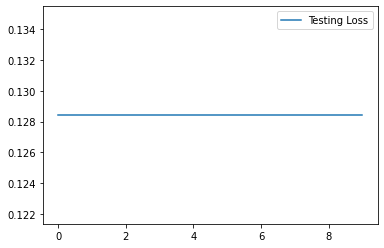

In [58]:
plt.plot(test_loss_history, label="Testing Loss")
plt.legend()
plt.show()

## Saving your model
Using `torch.save`, save your model for future loading.

In [59]:
torch.save({'epoch': num_epochs,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},'MNIST.pt')